In [1]:
# Import libraries
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from natsort import natsorted
from skimage import exposure
%matplotlib inline

### Load calibration data

In [2]:
# Load mtx, dist from pickle file saved
with open('calibration.p', mode='rb') as file:
    calibration = pickle.load(file)
    mtx = calibration["mtx"]
    dist = calibration["dist"]

### Define helper functions

In [3]:
# Functions
def read_img(img):
    return mpimg.imread(img)

def fix_distortion(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def normalize(sobel_in):
    return np.uint8(255 * sobel_in / np.max(sobel_in))

def histo(img):
    
    output = np.copy(img)
    
#     if len(img.shape) > 2:

#         if np.max(img) <= 1.0:
#             output = (np.copy(img)*255).astype(np.uint8)
#         else:
#             output = np.copy(img)
#     else:

#         if np.max(img) <= 1.0:
#             output = (np.copy(img)*255).astype(np.uint8)
#         else:
#             output = np.copy(img)
    
    return np.sum(output[output.shape[0]//2:,:], axis=0)

def eq_hist(img):
    return cv2.equalizeHist(img)

def sigmoid(img):
    return exposure.adjust_sigmoid(img)

def adjust_intensity(img):
    return exposure.rescale_intensity(img)

def adapthist(img):
    return exposure.equalize_adapthist(img)

def roi(img, vert = 'warped'):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
#     vertices = np.array([[()]])
    #define vertices
    shape = img.shape
    if vert == 'warped':
        vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                          (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)
    elif vert == 'unwarped':
        # FROM https://github.com/wonjunee/Advanced-Lane-Finding/blob/master/Advanced-Lane-Finding-Submission.ipynb
        # Defining vertices for marked area
        imshape = img.shape
        left_bottom = (100, imshape[0])
        right_bottom = (imshape[1]-20, imshape[0])
        apex1 = (610, 410)
        apex2 = (680, 410)
        inner_left_bottom = (310, imshape[0])
        inner_right_bottom = (1150, imshape[0])
        inner_apex1 = (700,480)
        inner_apex2 = (650,480)
        vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
#     ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def sobel_helper(img, orient = 'x', k = 3):
    if orient == 'x':
        return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=k)
    if orient =='y':
        return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=k)

def binary_output(output, thresh=(0, 255)):
    temp = np.zeros_like(output)
    temp[(output >= thresh[0]) & (output <= thresh[1])] = 1
    return temp


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = grayscale(img)

    if orient =='x':
        sobel = sobel_helper(gray, 'x', sobel_kernel)
        abs_sobel = np.absolute(sobel)
    if orient =='y':
        sobel = sobel_helper(gray, 'y', sobel_kernel)
        abs_sobel = np.absolute(sobel)

    norm_sobel = normalize(abs_sobel)

    output = binary_output(norm_sobel, thresh)

    return output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = grayscale(img)

    sobelx = sobel_helper(gray, 'x', sobel_kernel)
    sobely = sobel_helper(gray, 'y', sobel_kernel)

    mag_sobel = np.sqrt((sobelx ** 2) + (sobely ** 2))

    norm_sobel = normalize(mag_sobel)

    output = binary_output(norm_sobel, mag_thresh)

    return output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = grayscale(img)

    sobelx = sobel_helper(gray, 'x', sobel_kernel)
    sobely = sobel_helper(gray, 'y', sobel_kernel)

    grad_dir = np.arctan2(np.abs(sobely), np.abs(sobelx))

    output = binary_output(grad_dir, thresh)

    return output

def color_space(img, color = 'HLS', thresh=(0,255), selection = 0):
    
    if color == 'RGB':
        pass
    else:
        color_dict = {'HLS': 53, 'GRAY': 7, 'XYZ': 33, 'HSV': 41, 
                      'LAB': 45, 'LUV': 51, 'YUV': 83, 'YCrCb': 37}

        img = cv2.cvtColor(img, color_dict[color])
    
    channel_selection = selection
    channel = img[:,:,channel_selection]
    
    binary = binary_output(channel, thresh)
    
    return binary

### Explore and determine masking

Explore all the color transform, gradients to find optimized masking function

In [4]:
test_images = natsorted(os.listdir('test_images'))

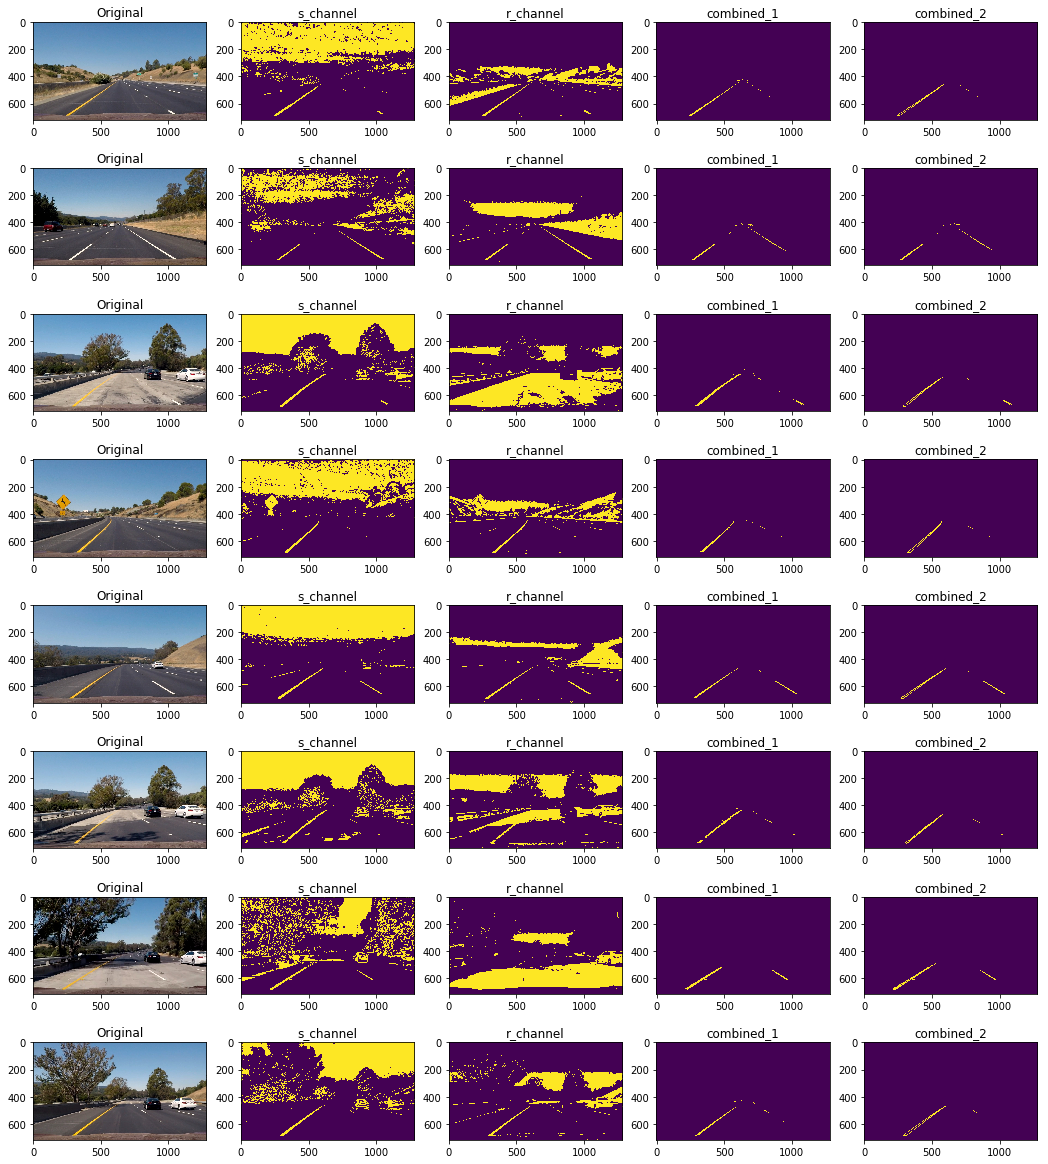

In [5]:
# Find thresholds

plt.figure(figsize=(18,21))
plot_titles = ['Original', 's_channel', 'r_channel', 'combined_1', 'combined_2']

for i, img in enumerate(test_images):
    img = read_img('test_images/' + img)
#     img = sigmoid(img)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(150, 200))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.2, 1.5))
    hls_s = color_space(img, color='HLS', thresh=(100,255), selection=2)
    hls_l = color_space(img, color='HLS', thresh=(120,255), selection=1)
    rgb_r = color_space(img, 'RGB', thresh=(150,255), selection = 0)
    rgb_g = color_space(img, 'RGB', thresh=(150,255), selection = 1)
    luv_l = color_space(img, 'LUV', thresh=(225,255), selection = 0)
    lab_b = color_space(img, 'LAB', thresh=(155,200), selection = 2)
    yuv_y = color_space(img, 'YUV', thresh=(150,255), selection = 0)
    hsv_v = color_space(img, 'HSV', thresh=(30,125), selection = 2)
    hsv_s = color_space(img, 'HSV', thresh=(0,5), selection = 1)
    hsv_h = color_space(img, 'HSV', thresh=(70,250), selection = 0)
    ycr_y = color_space(img, 'YCrCb', thresh=(120,150), selection =1)
    combined_1 = np.zeros_like(dir_binary)
    combined_1[(((rgb_r==1) & (rgb_g==1)) & (hls_l==1)) & (((hls_s==1) | ((gradx==1) & (dir_binary==1))))]=1
    combined_2 = np.zeros_like(rgb_r)
#     combined_2[((rgb == 1) | (hls == 1)) | (gradx == 1) & ((dir_binary == 1))] = 1
    combined_2[(rgb_r == 1) | (hls_s == 1)] = 1
    combined_3 = np.zeros_like(dir_binary)
    combined_3[(luv_l == 1) | (lab_b == 1)] = 1
    

    combined_1 = roi(combined_1, 'unwarped')
    combined_2 = roi(combined_2, 'unwarped')
    combined_3 = roi(combined_3, 'unwarped')
    
    mask_list = [img, hls_s, rgb_r, combined_1, combined_3]
    
    for k in range(5):
        plt.subplot(len(test_images), 5, k+1+i*5)
        plt.imshow(mask_list[k])
        plt.title(plot_titles[k])

        
plt.show()

In [6]:
def masking(img):

    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.2, 1.5))
    hls_s = color_space(img, color='HLS', thresh=(100,255), selection=2)
    hls_l = color_space(img, color='HLS', thresh=(120,255), selection=1)
    rgb_r = color_space(img, 'RGB', thresh=(150,255), selection = 0)
    rgb_g = color_space(img, 'RGB', thresh=(150,255), selection = 1)
    luv_l = color_space(img, 'LUV', thresh=(225,255), selection = 0)
    lab_b = color_space(img, 'LAB', thresh=(155,200), selection = 2)
    combined_1 = np.zeros_like(dir_binary)
    combined_1[(((rgb_r==1) & (rgb_g==1)) & (hls_l==1)) & (((hls_s==1) | ((gradx==1) & (dir_binary==1))))]=1
    combined_2 = np.zeros_like(rgb_r)
#     combined_2[((rgb == 1) | (hls == 1)) | (gradx == 1) & ((dir_binary == 1))] = 1
    combined_2[(rgb_r == 1) | (hls_s == 1)] = 1
    combined_3 = np.zeros_like(dir_binary)
    combined_3[(luv_l == 1) | (lab_b == 1)] = 1

#     combined_2 = roi(combined_2, vertices)
    
    return combined_1

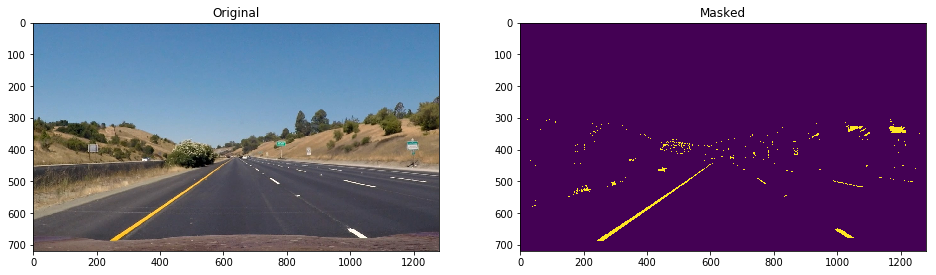

In [7]:
image = read_img('test_images/straight_lines1.jpg')
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.title('Original')
plt.imshow(image)

plt.subplot(122)
plt.title('Masked')
plt.imshow(masking(image))

plt.show()

### Perspective Transform

In [8]:
def warp(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    top_left=np.array([corners[0,0],0])
    top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,top_left+offset,top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M, src, dst, Minv

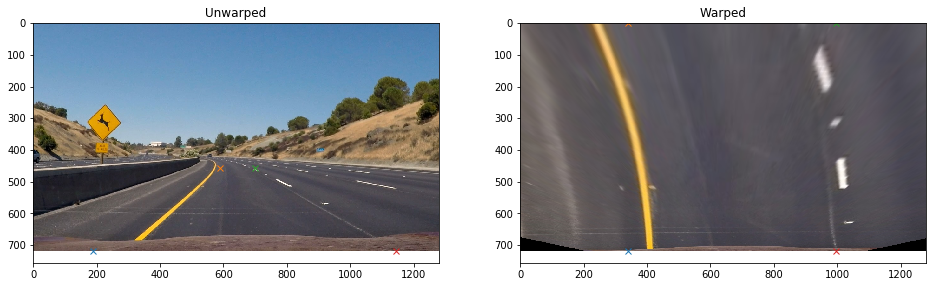

In [9]:
image = read_img('test_images/test2.jpg')
warped_image = fix_distortion(image)
warped_image, M, src, dst, Minv = warp(warped_image)

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.title('Unwarped')
plt.imshow(image)
for i in range(4):
    plt.plot(src[i][0], src[i][1], 'x')

plt.subplot(122)
plt.title('Warped')
plt.imshow(warped_image)
for i in range(4):
    plt.plot(dst[i][0], dst[i][1], 'x')

plt.show()

straight_lines1.jpg


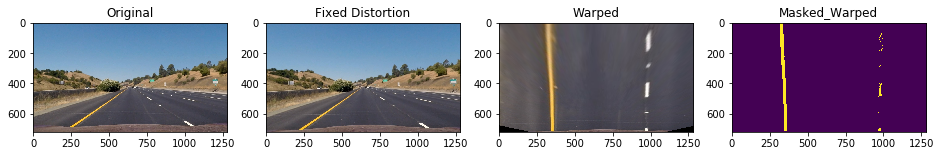

straight_lines2.jpg


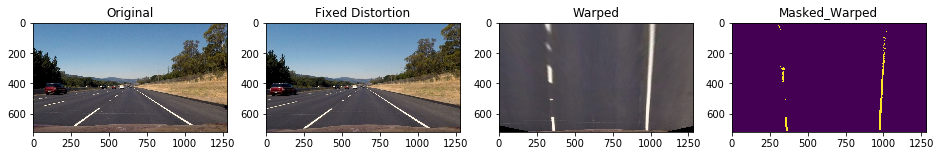

test1.jpg


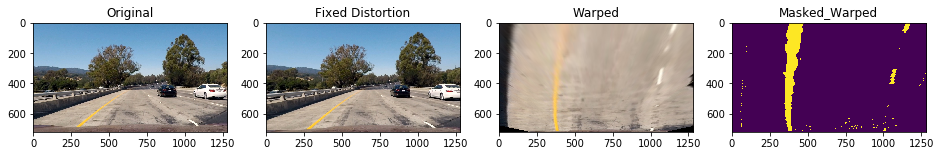

test2.jpg


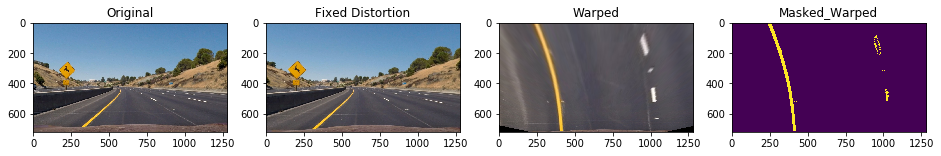

test3.jpg


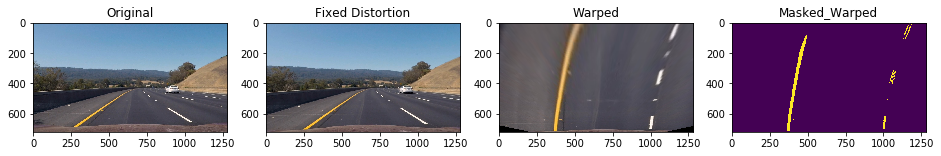

test4.jpg


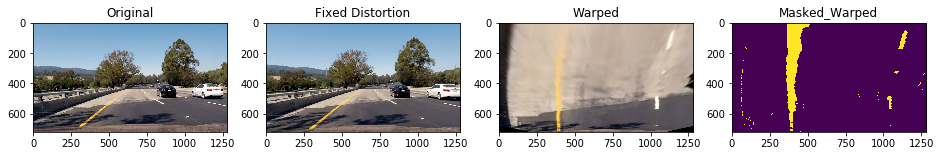

test5.jpg


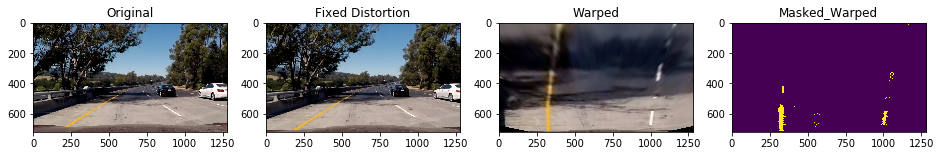

test6.jpg


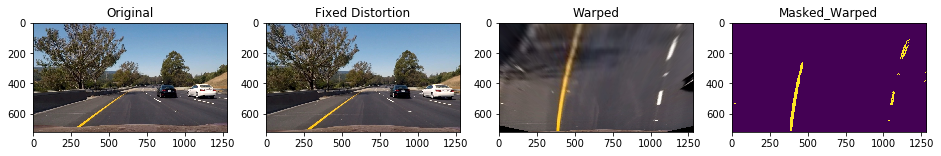

In [10]:
# plt.figure(figsize=(18,21))
for i, image in enumerate(test_images):
    img = read_img('test_images/' + image.strip())
    fixed_image = fix_distortion(img)
    warped_image = warp(fixed_image)[0]
    masked_warped = masking(warped_image)
    
    print(image)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.title('Original')
    plt.imshow(img)
    plt.subplot(142)
    plt.title('Fixed Distortion')
    plt.imshow(fixed_image)
    plt.subplot(143)
    plt.title('Warped')
    plt.imshow(warped_image)
    plt.subplot(144)
    plt.title('Masked_Warped')
    plt.imshow(masked_warped)
    plt.show()


In [11]:
def pipeline(img):
    
    img = fix_distortion(img)
    img = masking(img)
#     img = roi(img, 'unwarped')
    img = warp(img)[0]
#     img = roi(img)
   
    return img

### Detect lanes and draw

In [12]:
def blind_find_lane(image):
    
    # Create histogram of processed image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
#     blanky = np.zeros_like(image)
    out_img = (np.dstack((image, image, image))*255).astype(np.uint8)
    
    # Find midpoints, and peak points of left and right half of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
#     boxes = []
    
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Extract window search box coordinates
#         boxes.append(((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)))
#         boxes.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(out_img, np.int_([pts_left]), isClosed = False, color=(255,255,0), thickness = 20)
    cv2.polylines(out_img, np.int_([pts_right]), isClosed = False, color=(255,255,0), thickness = 20)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, out_img

    
def draw_lane(image, left, right, color = 'green', linewidth = 3):
    
    ploty = np.linspace(0, 719, num=720)
    
    plt.xlim(0, img.shape[1])
    plt.ylim(0, img.shape[0])
    
    plt.plot(left, ploty, color=color, linewidth=linewidth)
    plt.plot(right, ploty, color=color, linewidth=linewidth)
    plt.gca().invert_yaxis()
    
def fill_lane(image, left, right, l = True, r = True, color = 'green', linewidth = 3):
    
    # Create blank canvas
    zero_image = np.zeros_like(image).astype(np.uint8)
    zero_image = np.dstack((zero_image, zero_image, zero_image))
    
#     plt.plot(left, ploty, color=color, linewidth=linewidth)
#     plt.plot(right, ploty, color=color, linewidth=linewidth)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    pts_left = np.array([np.transpose(np.vstack([left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    if l == True:
        cv2.polylines(zero_image, np.int_([pts_left]), isClosed = False, color=(0,0,255), thickness = 40)
    else:
        cv2.polylines(zero_image, np.int_([pts_left]), isClosed = False, color=(255,0,0), thickness = 40)
    if r == True:
        cv2.polylines(zero_image, np.int_([pts_right]), isClosed = False, color=(0,0,255), thickness = 40)
    else:
        cv2.polylines(zero_image, np.int_([pts_right]), isClosed = False, color=(255,0,0), thickness = 40)
    
    cv2.fillPoly(zero_image, np.int_([pts]), (0, 255, 0))
    
    return zero_image
    
def unwarp(image, Minv):
    
    image = cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0]))
    
    return image

def combine_result(original, image):
    
    result = cv2.addWeighted(original, 1, image, 0.3, 0)
    
    return result
    
def add_results(image):
    
  
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature:"
    cv2.putText(image, text, (50,50), font, 1, (255,255,255), 2)
    text = "How far from center"
    cv2.putText(image, text, (50,100), font, 1, (255,255,255), 2)
    
    return image

def fit_polynomial(poly, y, marg = 0):
    
    poly = np.asarray(poly)
    y = np.asarray(y)
    marg = np.asarray(marg)
    return ((poly[0] * y ** 2) + (poly[1] * y) + poly[2] + marg)

def visualize_lane_find(img, left, right):

    if len(img.shape) > 2:
        color = (255, 255, 0)
        if np.max(img) <= 1.0:
            output = (np.copy(img)*255).astype(np.uint8)
        else:
            output = np.copy(img)
    else:
        color = 200
        if np.max(img) <= 1.0:
            output = (np.copy(img)*255).astype(np.uint8)
        else:
            output = np.copy(img)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right, ploty])))])
    
    cv2.polylines(output, np.int_([pts_left]), isClosed = False, color=color, thickness = 20)
    cv2.polylines(output, np.int_([pts_right]), isClosed = False, color=color, thickness = 20)
    
    return output

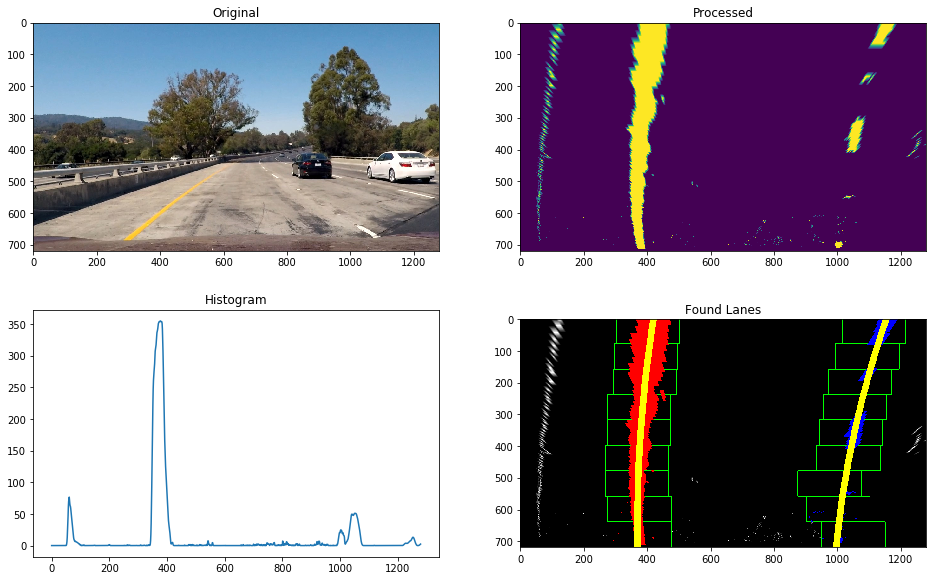

In [13]:
image = read_img('test_images/test1.jpg')

processed_img = pipeline(image)

histogram = histo(processed_img)

leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, out_img = blind_find_lane(processed_img)

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Processed')
plt.imshow(processed_img)

plt.subplot(223)
plt.title('Histogram')
plt.plot(histogram)

plt.subplot(224)
plt.title('Found Lanes')
plt.imshow(out_img)

plt.show()

In [14]:
def calc_curvature(y, x):

    y_eval = np.max(y) / 2
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit converted x,y values to polynomial
    fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
    
    # Calculate the curvature
    curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    
    return curverad

def find_center(left, right):
    
    left = left[0]*720**2 + left[1]*720 + left[2]
    right = right[0]*720**2 + right[1]*720 + right[2]
   
    center = 640 - ((right + left) / 2)
    
    xm_per_pix = 3.7/700 
    
    ret = center * xm_per_pix
    
    return ret


In [15]:
def total_process(img):
    
    original = img
    original = fix_distortion(original)
    
    ploty = np.linspace(0, original.shape[0]-1, original.shape[0] )
    
    processed = pipeline(img)
    
    leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, out_img = blind_find_lane(processed)

    left_int_top = fit_polynomial(left_fit, 0)
    right_int_top = fit_polynomial(right_fit, 0)
    left_int_bot = fit_polynomial(left_fit, 720)
    right_int_bot = fit_polynomial(right_fit, 720)
#     print (left_fit, right_fit)
#     print (left_int_top, right_int_top, left_int_bot, right_int_bot)
#     print (left_fitx)
    
    filled_image = fill_lane(processed, left_fitx, right_fitx)    
    
    unwarped = unwarp(filled_image, Minv)
    
    result = combine_result(original, unwarped)
    
    curvature_left = calc_curvature(ploty, left_fitx)
    curvature_right = calc_curvature(ploty, right_fitx)
    
    center = find_center(left_fit, right_fit)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    text = "Radius of Left Curvature: {:.2f}".format(curvature_left)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Radius of Right Curvature: {:.2f}".format(curvature_right)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    if center < 0:
        text = "{:.2f} left of center".format(abs(center))
    else:
        text = "{:.2f} right of center".format(abs(center))
    cv2.putText(result, text, (50,150), font, 1, (255,255,255), 2)
    
    
    return result
    

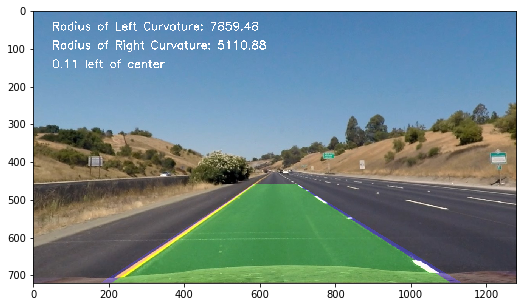

In [16]:
image = read_img('test_images/straight_lines1.jpg')
processed_img = total_process(image)
plt.figure(figsize=(16,5))
plt.imshow(total_process(image))
plt.show()

### Define class to keep track of each line

In [27]:
from collections import deque

class Line():
    
    def __init__(self, side):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # was their enough points found through line search
        self.trigger = False
        
        # Set which side the Line object is
        self.side = side
        
        # Count how many values in history list
        self.history = 0
        
        # fit from previous iteration
        self.fit = None
        
        # fitted x values from previous iteration
        self.fitx = None
        
        # recent list of fit values
        self.fit_list = deque(maxlen = 10)
        
        # recent list of x values
        self.fitx_list = deque(maxlen = 10)
        
        # average of last 10 fits
        self.avg_fit = None#np.mean(self.fit_list, axis=0)
        
        # average of last 10 x values
        self.avg_fitx = None#np.mean(self.fitx_list, axis=0)
        
        # intercept top
        self.int_top = None
        
        # intercept bot
        self.int_bot = None
        
        # list of top intercepts
        self.int_top_list = deque(maxlen = 10)
        
        # list of bot intercepts
        self.int_bot_list = deque(maxlen = 10)
        
        # average of top intercepts
        self.avg_top = None#np.mean(self.int_top_list, axis=0)
        
        # average of bot intercepts
        self.avg_bot = None#np.mean(self.int_bot_list, axis=0)
    
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        # Keep number of total frames
        self.total_count = 0
        
        # Keep number of good frames
        self.good_count = 0
        
        # Keep number of bad frames
        self.bad_count = 0
        
        self.points = None
        
        self.x = None
        
        self.y = None
        
        self.boxes = []
        
    def blind_find_lane(self, image):
        
        side = self.side
        
        out_img = (np.dstack((image, image, image))*255).astype(np.uint8)

        # Create histogram of processed image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

        # Find midpoints, and peak points of left and right half of the histogram
        midpoint = np.int(histogram.shape[0]/2)
        
        if self.side == 'left':
            x_base = np.argmax(histogram[:midpoint])
        elif self.side == 'right':
            x_base = np.argmax(histogram[:midpoint]) + midpoint
        else:
            raise ValueError

        # Choose the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(image.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        x_current = x_base

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive lane pixel indices
        lane_inds = []
        
        self.boxes = []

        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)
            
            self.boxes.append(((win_x_low, win_y_low), (win_x_high, win_y_high)))

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
#         print (self.side, len(lane_inds))

        # Extract line pixel positions
        self.x = nonzerox[lane_inds]
#         print (self.side, len(x))

        self.y = nonzeroy[lane_inds]
    
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        
    
        if len(self.x) < 100:
            
            self.fit = None
            self.fitx = None
            self.int_bot = None
            self.int_top = None
            self.points = None
            self.trigger = False
        
        else:

            # Fit a second order polynomial
            self.fit = np.polyfit(self.y, self.x, 2)
            self.fitx = self.fit_polynomial(self.fit, ploty)
            self.int_bot = self.fit_polynomial(self.fit, 720)
            self.int_top = self.fit_polynomial(self.fit, 0)
            self.trigger = True
        
        if self.trigger == True:
            
            if self.side == 'left':
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
                        
            self.points = np.array([np.transpose(np.vstack([self.fitx, ploty]))])

            cv2.polylines(out_img, np.int_([self.points]), isClosed = False, color=(255,255,0), thickness = 20)


        return out_img

    def exp_find_lane(self, image, fit):
        
#         side = self.side
        out_img = (np.dstack((image, image, image))*255).astype(np.uint8)
        
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        lane_inds = ((nonzerox > self.fit_polynomial(fit, nonzeroy, marg = -margin)) & (nonzerox < self.fit_polynomial(fit, nonzeroy, marg = margin)))

        # Again, extract left and right line pixel positions
        self.x = nonzerox[lane_inds]
        self.y = nonzeroy[lane_inds]

        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        
        if len(self.x) < 100:
            
            self.fit = None
            self.fitx = None
            self.int_bot = None
            self.int_top = None
            self.points = None
            self.trigger = False
        
        else:

            # Fit a second order polynomial
            self.fit = np.polyfit(self.y, self.x, 2)
            self.fitx = self.fit_polynomial(self.fit, ploty)
            self.int_bot = self.fit_polynomial(self.fit, 720)
            self.int_top = self.fit_polynomial(self.fit, 0)
            self.trigger = True
       
        if self.trigger == True:
            
            if self.side == 'left':
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
                        
            self.points = np.array([np.transpose(np.vstack([self.fitx, ploty]))])

            cv2.polylines(out_img, np.int_([self.points]), isClosed = False, color=(255,255,0), thickness = 20)
            
            line_window1 = np.array([np.transpose(np.vstack([self.fitx-margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.fitx+margin, ploty])))])
            line_pts = np.hstack((line_window1, line_window2))
            
            window_img = np.zeros_like(out_img)
            cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        return result
    
    def fit_polynomial(self, poly, y, marg = 0):
        poly = np.asarray(poly)
        y = np.asarray(y)
        marg = np.asarray(marg)
        return ((poly[0] * y ** 2) + (poly[1] * y) + poly[2] + marg)
    
    def calc_curvature(self, y, x):
    
        # Define y-value for location of curvature,  I chose middle y-value that corresponds
        # middle of the image
        y_eval = np.max(y) / 2

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit converted x,y values to polynomial
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)

        # Calculate the curvature
        curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])

    #     print (curverad)

        return curverad

    def find_center(self, left, right):

#         left = left[0]*720**2 + left[1]*720 + left[2]
#         right = right[0]*720**2 + right[1]*720 + right[2]

    #     center = (1.5 * left - right) / 2
        center = 640 - ((right + left) / 2)

        xm_per_pix = 3.7/700 

        ret = center * xm_per_pix

        return ret

    
def sanity_check(left_fitx, right_fitx):
    
    left_lane_status = False
    right_lane_status = False
    
    if (((max(abs(right_fitx))-max(abs(left_fitx))) > 600) & ((max(abs(right_fitx)) - max(abs(left_fitx))) < 800)):
        if (((min(abs(right_fitx))-min(abs(left_fitx))) > 600) & ((min(abs(right_fitx))-min(abs(left_fitx))) < 800)):
#             print('lane wide enough')
#         left_lane_status = True
#         right_lane_status = True
    
            if (max(abs(left_fitx)) - min(abs(left_fitx))) < 300:
#                 print('left lane seems ok')
                left_lane_status = True
            if (max(abs(right_fitx)) - min(abs(right_fitx))) < 300:
#                 print('right lane seems ok')
                right_lane_status = True
            
    return left_lane_status, right_lane_status
            

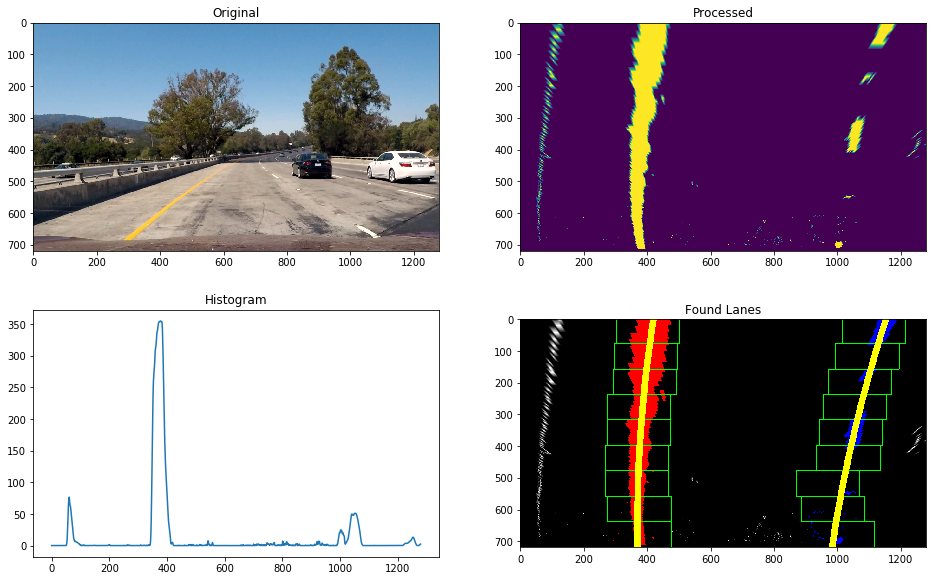

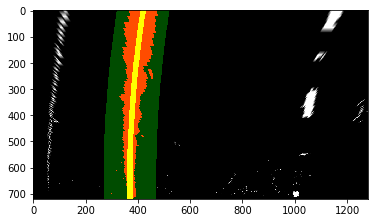

In [28]:
image = read_img('test_images/test1.jpg')

left = Line('left')
right = Line('right')

processed_img = pipeline(image)

histogram = histo(processed_img)

left_img = left.blind_find_lane(processed_img)
right_img = right.blind_find_lane(processed_img)

final_img = (np.dstack((processed_img, processed_img, processed_img))*255).astype(np.uint8)
final_img[left.y, left.x] = [255, 0, 0]
final_img[right.y, right.x] = [0, 0, 255]

for box in left.boxes:
    cv2.rectangle(final_img, box[0], box[1], (0,255,0), 2)
for box in right.boxes:
    cv2.rectangle(final_img, box[0], box[1], (0,255,0), 2)
    
cv2.polylines(final_img, np.int_([left.points]), isClosed = False, color=(255,255,0), thickness = 20)
cv2.polylines(final_img, np.int_([right.points]), isClosed = False, color=(255,255,0), thickness = 20)

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title('Original')
plt.imshow(image)

plt.subplot(222)
plt.title('Processed')
plt.imshow(processed_img)

plt.subplot(223)
plt.title('Histogram')
plt.plot(histogram)

plt.subplot(224)
plt.title('Found Lanes')
plt.imshow(final_img)

plt.show()

left_img = left.exp_find_lane(processed_img, left.fit)
right_img = right.exp_find_lane(processed_img, right.fit)
plt.imshow(left_img)

In [19]:
def final_process(img):
    
    original = img
    original = fix_distortion(original)
    
    ploty = np.linspace(0, original.shape[0]-1, original.shape[0] )
    
    processed = pipeline(img)
    
    if left.detected == False:
        left_img = left.blind_find_lane(processed)
    else:
        left_img = left.exp_find_lane(processed, left.fit)
        
    if right.detected == False:
        right_img = right.blind_find_lane(processed)
    else:
        right_img = right.exp_find_lane(processed, right.fit)


    def check_line(line):
        if line.history < 10:
            return True
        else:
            if (abs(line.int_bot - line.avg_bot) <= 100) & (abs(line.int_top - line.avg_top) <= 100):
                return True
#             elif line
            else:
                return False
    
#     print (len(left_fitx))
    
    for line in [left, right]:
        
        
        if line.trigger == True:
        
            if line.history < 10:

                line.fit_list.append(line.fit)
                line.fitx_list.append(line.fitx)
                line.int_top_list.append(line.int_top)
                line.int_bot_list.append(line.int_bot)
                line.avg_fit = np.mean(line.fit_list, axis=0)
                line.avg_fitx = np.mean(line.fitx_list, axis=0)
                line.avg_top = np.mean(line.int_top_list, axis=0)
                line.avg_bot = np.mean(line.int_bot_list, axis=0)
                line.history = len(line.fit_list)
                line.good_count += 1
                line.detected = True
                
            else:
                
                if check_line(line) == True:
                    
                    line.fit_list.append(line.fit)
                    line.fitx_list.append(line.fitx)
                    line.int_top_list.append(line.int_top)
                    line.int_bot_list.append(line.int_bot)
                    line.avg_fit = np.mean(line.fit_list, axis=0)
                    line.avg_fitx = np.mean(line.fitx_list, axis=0)
                    line.avg_top = np.mean(line.int_top_list, axis=0)
                    line.avg_bot = np.mean(line.int_bot_list, axis=0)
                    line.history = len(line.fit_list)
                    line.good_count += 1
                    line.detected = True
                    
                else:
                    
                    line.bad_count += 1
                    line.detected = False
                
        else:
            
            line.bad_count += 1
            line.detected = False
    

    left.total_count += 1
    right.total_count += 1
#     print (len(left.current_x), left.history)
#     print (len(right.current_x), right.history)
    
    if left.detected == True:
        display_left = left.fitx
        center_left = left.int_bot
    else:
        display_left = left.avg_fitx
        center_left = left.avg_bot
    
    if right.detected == True:
        display_right = right.fitx
        center_right = right.int_bot
    else:
        display_right = right.avg_fitx
        center_right = right.avg_bot
    
    filled_image = fill_lane(processed, display_left, display_right, left.detected, right.detected)    
    
    unwarped = unwarp(filled_image, Minv)
    
    result = combine_result(original, unwarped)
    
    curvature_left = left.calc_curvature(ploty, display_left)
    curvature_right = left.calc_curvature(ploty, display_right)
    
    center = left.find_center(center_left, center_right)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    text = "Radius of Left Curvature: {:.2f} m".format(curvature_left)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Radius of Right Curvature: {:.2f} m".format(curvature_right)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    if center < 0:
        text = "{:.2f} m left of center".format(abs(center))
    else:
        text = "{:.2f} m right of center".format(abs(center))
    cv2.putText(result, text, (50,150), font, 1, (255,255,255), 2)
    if left.detected == False:
        text = "Left lane: Lost"
        cv2.putText(result, text, (50,200), font, 1, (255,0,0), 2)
    else:
        text = "Left lane: Found"
        cv2.putText(result, text, (50,200), font, 1, (0,255,0), 2)
    
    if right.detected == False:
        text = "Right lane: Lost"
        cv2.putText(result, text, (50,250), font, 1, (255,0,0), 2)
    else:
        text = "Right lane: Found"
        cv2.putText(result, text, (50,250), font, 1, (0,255,0), 2)
    text = "Frame: {}".format(left.total_count)
    cv2.putText(result, text, (1000,50), font, 1, (255,255,255), 2)
    
    left_img = cv2.resize(left_img, (300,150))
    right_img = cv2.resize(right_img, (300,150))
    x_offset = 850
    left_y_offset = 100

    right_y_offset = 295
    result[left_y_offset:left_y_offset+left_img.shape[0], x_offset:x_offset+left_img.shape[1]] = left_img
    result[right_y_offset:right_y_offset+right_img.shape[0], x_offset:x_offset+right_img.shape[1]] = right_img
    
    text = "Left search"
    cv2.putText(result, text, (850,95), font, 1, (255,255,255), 2)
    text = "Right search"
    cv2.putText(result, text, (850,280), font, 1, (255,255,255), 2)
    
    return result

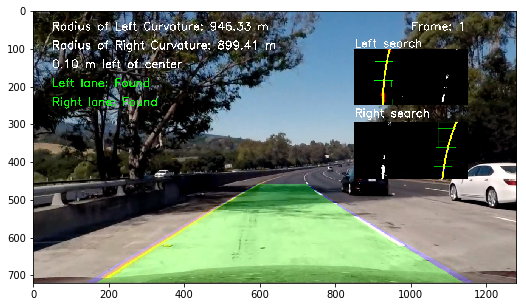

In [20]:
left = Line('left')
right = Line('right')
image = (read_img('test_images/test5.jpg'))
plt.figure(figsize=(16,5))
plt.imshow(final_process(image))
plt.show()

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
left = Line('left')
right = Line('right')

output = 'final_submission.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(final_process)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_submission.mp4
[MoviePy] Writing video final_submission.mp4


100%|████████████████▉| 1260/1261 [06:46<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_submission.mp4 

Wall time: 6min 47s


In [31]:
left = Line('left')
right = Line('right')

output2 = 'challenge_submission.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
output_clip2 = clip2.fl_image(final_process)
%time output_clip2.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video challenge_submission.mp4
[MoviePy] Writing video challenge_submission.mp4


100%|███████████████████| 485/485 [02:32<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_submission.mp4 

Wall time: 2min 32s


In [24]:
# left = Line('left')
# right = Line('right')

# output3 = 'test999.mp4'
# clip3 = VideoFileClip('harder_challenge_video.mp4')
# output_clip3 = clip3.fl_image(final_process)
# %time output_clip3.write_videofile(output3, audio=False)